## Итак что у нас есть:

* ### Тренировочные данные состоят из 323 наблюдений, в каждом из которых есть 40 сигналов датчиков снятые 100 раз с равными промежутками времени (на вскидку всё наблюдение это 100 миллисекунд)

* ### Тренировочные данные получены следующим образомЖ пилоту показываю жест - пилот повторяет жест (всё это время датчики регистрирую какие-то параметры) логично, что между командой на выполнение жеста и самим жестом проходит како-то время ($\Delta t$) 

## Содержание <a class="anchor" id=0></a>

1. [Вариант 1 - Грубый `time_shift`](#1)
1. [Вариант 2 - Ведём состояние покоя на каждый датчик](#2)


***
## Вариант 1 <a class="anchor" id=1></a>

[к содержанию](#0)

### Попробум грубо компенсировать $\Delta t$ и выполнить предсказания используюя `RandomForestClassifier`

# Read data

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import optuna

In [156]:
data_train = np.load('X_train.npy')
data_test = np.load('X_test.npy')

data_y_train = pd.read_csv('y_train.csv')
#y_test = pd.read_csv('y_test.csv')
data_y_test = pd.read_csv('sample_submission.csv')

print(data_train.shape, data_y_train.shape)
print(data_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100)


In [157]:
# Определим функцию сдвигателя показаний на заданный временной интервал
def shifter(data, n=10):
    lst = list(data)
    for i in range(n):
        lst.insert(0, i*0)
        lst.pop(-1)
       
    return lst

In [158]:
data_y_train['class'] = shifter(data_y_train['class'], 13)

In [159]:
data_y_train[['sample_id', 'timestep']] = data_y_train['sample-timestep'].str.split('-', 1, expand=True).astype(int)
data_y_train = data_y_train.pivot(index='sample_id', columns='timestep', values='class')
data_y_train_index = data_y_train.index
data_y_train = data_y_train.sort_index() # на всякий случай
data_y_train = data_y_train.values

print(data_y_train.shape)
data_y_train

(323, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

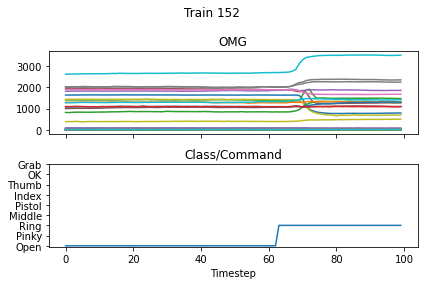

In [164]:
i = np.random.randint(data_y_train.shape[0])

fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(data_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(data_y_train[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

In [165]:
# Подготовом данные к загрузке в модель
list_1 = []
list_2 = []
list_3 = []
list_4 = []

for i in range(data_train.shape[0]):
    list_1.append(data_train[i].T)

arr_1 = np.array(list_1)

for i in range(arr_1.shape[0]):
    list_2.extend(arr_1[i])

for i in range(data_test.shape[0]):
    list_3.append(data_test[i].T)

arr_2 = np.array(list_3)

for i in range(arr_2.shape[0]):
    list_4.extend(arr_2[i])
    
X = np.array(list_2)

X_sub = np.array(list_4)

X.shape, X_sub.shape

((32300, 40), (5400, 40))

In [167]:
df_y_train = []
for idx, arr in zip(data_y_train_index, data_y_train):
    
    series = pd.Series(arr)
    series.index = [f"{idx}-{i}" for i in series.index]
    df_y_train.append(series)
    
df_y_train = pd.concat(df_y_train)
df_y_train = df_y_train.reset_index()
df_y_train.columns = ["sample-timestep", "class"]
df_y_train

y = df_y_train.drop('sample-timestep', axis=1)
y = np.array(y).ravel()

In [168]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42
)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(27455, 40) (27455,) (4845, 40) (4845,)


In [169]:
# Отмасштабируем данные
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_sub = scaler.transform(X_sub)

In [170]:
# Попробуем несколько классификаторов (с настройками по умолчанию)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

RFC = RandomForestClassifier(random_state=42)


RFC.fit(X_train, y_train)


y_train_pred_rfc = RFC.predict(X_train)
y_valid_pred_rfc = RFC.predict(X_valid)


print('\nRandomForestClassifier')
print('F-1 score on train: {:.6f}'.format(metrics.f1_score(y_train, y_train_pred_rfc, average="macro")))
print('F-1 score on valid: {:.6f}'.format(metrics.f1_score(y_valid, y_valid_pred_rfc, average="macro")))



RandomForestClassifier
F-1 score on train: 1.000000
F-1 score on valid: 0.955474


### Попробуем подобрать гиперпараметры и маленько улучшить целевую метрику

In [171]:
# Подберём гиперпараметры 
import optuna
def optuna_rfc(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 70, 570, 1)
  max_depth = trial.suggest_int('max_depth', 10, 50, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 6, 1)

  # создаем модель
  model_op = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    criterion='entropy',
                                    random_state=42)
  # обучаем модель
  model_op.fit(X_train, y_train)
  score = metrics.f1_score(y_valid, model_op.predict(X_valid), average="macro")

  return score

In [172]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rfc, n_trials=10)

[I 2023-04-20 09:15:02,966] A new study created in memory with name: RandomForestClassifier
[I 2023-04-20 09:15:35,122] Trial 0 finished with value: 0.9470760208049656 and parameters: {'n_estimators': 403, 'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9470760208049656.
[I 2023-04-20 09:16:11,830] Trial 1 finished with value: 0.9529253108592558 and parameters: {'n_estimators': 445, 'max_depth': 49, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9529253108592558.
[I 2023-04-20 09:16:29,161] Trial 2 finished with value: 0.9415592337129337 and parameters: {'n_estimators': 259, 'max_depth': 11, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9529253108592558.
[I 2023-04-20 09:16:41,595] Trial 3 finished with value: 0.9469298313343959 and parameters: {'n_estimators': 157, 'max_depth': 35, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.9529253108592558.
[I 2023-04-20 09:16:57,784] Trial 4 finished with value: 0.9422658349754703 and parameters: {'n_

CPU times: total: 3min 49s
Wall time: 3min 50s


In [189]:
study.optimize(optuna_rfc, n_trials=20)

[I 2023-04-20 09:56:03,469] Trial 31 finished with value: 0.9558151417366739 and parameters: {'n_estimators': 284, 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.95652169431791.
[I 2023-04-20 09:56:22,378] Trial 32 finished with value: 0.9563173520698006 and parameters: {'n_estimators': 221, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.95652169431791.
[I 2023-04-20 09:56:49,828] Trial 33 finished with value: 0.9530281916106154 and parameters: {'n_estimators': 326, 'max_depth': 23, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.95652169431791.
[I 2023-04-20 09:57:12,239] Trial 34 finished with value: 0.9558067503530621 and parameters: {'n_estimators': 263, 'max_depth': 31, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.95652169431791.
[I 2023-04-20 09:57:31,533] Trial 35 finished with value: 0.9525467827719503 and parameters: {'n_estimators': 231, 'max_depth': 34, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.9

In [193]:
# выводим результаты на обучающей выборке

#best_param = (n_estimators=192,max_depth=28,min_samples_leaf=2,criterion='entropy', random_state=42    )

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на валидационном наборе: {:.5f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 192, 'max_depth': 28, 'min_samples_leaf': 2}
f1_score на валидационном наборе: 0.95652


In [194]:
rf_opt = RandomForestClassifier(
    n_estimators=192,
    max_depth=28,
    min_samples_leaf=2,
    criterion='entropy', 
    random_state=42    
)

rf_opt.fit(X_train, y_train)

y_train_pred = rf_opt.predict(X_train)
y_valid_pred = rf_opt.predict(X_valid)

print('F-1 score on train: {:.6f}'.format(metrics.f1_score(y_train, y_train_pred, average="macro")))
print('F-1 score on valid: {:.6f}'.format(metrics.f1_score(y_valid, y_valid_pred, average="macro")))

F-1 score on train: 0.997940
F-1 score on valid: 0.956522


In [195]:
y_test_pred = rf_opt.predict(X_sub)

In [196]:
data_y_test = pd.read_csv('sample_submission.csv')
data_y_test['class'] = y_test_pred
data_y_test.set_index('sample-timestep', inplace=True)
data_y_test['class'].value_counts()

0    3401
6     282
5     279
3     266
2     260
8     260
7     259
4     207
1     186
Name: class, dtype: int64

In [197]:
data_y_test.to_csv('sample_submission_rfc.csv')

In [198]:
data_y_test.reset_index(inplace=True)
data_y_test[['sample_id', 'timestep']] = data_y_test['sample-timestep'].str.split('-', 1, expand=True).astype(int)
data_y_test = data_y_test.pivot(index='sample_id', columns='timestep', values='class')
data_y_test_index = data_y_test.index
data_y_test = data_y_test.sort_index() # на всякий случай
data_y_test = data_y_test.values

print(data_y_test.shape)
data_y_test

(54, 100)


array([[4, 4, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

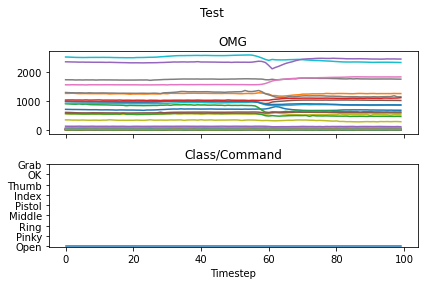

In [206]:
i = np.random.randint(data_y_test.shape[0])
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(data_test[i].T)
axx[0].set_title('OMG')

axx[1].plot(data_y_test[i])

axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Test')

plt.tight_layout()

***
## Вариант 2 <a class="anchor" id=2></a>

[к содержанию](#0)


In [859]:
data_train = np.load('X_train.npy')
data_test = np.load('X_test.npy')

data_y_train = pd.read_csv('y_train.csv')
#y_test = pd.read_csv('y_test.csv')
data_y_test = pd.read_csv('sample_submission.csv')

data_y_train[['sample_id', 'timestep']] = data_y_train['sample-timestep'].str.split('-', 1, expand=True).astype(int)
data_y_train = data_y_train.pivot(index='sample_id', columns='timestep', values='class')
data_y_train_index = data_y_train.index
data_y_train = data_y_train.sort_index() # на всякий случай
data_y_train = data_y_train.values

print(data_y_train.shape)
data_y_train

df_y_train = []
for idx, arr in zip(data_y_train_index, data_y_train):
    
    series = pd.Series(arr)
    series.index = [f"{idx}-{i}" for i in series.index]
    df_y_train.append(series)
    
df_y_train = pd.concat(df_y_train)
df_y_train = df_y_train.reset_index()
df_y_train.columns = ["sample-timestep", "class"]
df_y_train

y = df_y_train.drop('sample-timestep', axis=1)
y = np.array(y).ravel()

print(data_train.shape, data_y_train.shape)
print(data_test.shape)

(323, 100)
(323, 40, 100) (323, 100)
(54, 40, 100)


In [928]:
def trending(data, n=0.082222):
    """_сглаживатель_

    Args:
        n (float, optional): _процент сглаживания шума_. Defaults to 0.10.

    Returns:
        _type_: _сглаженные данные_
    """
    trend_list = []
    data_0 = data[0]
    delta = data_0 * n
    for i in range(len(data)-1):
        if abs(data[i] - data_0) < delta:
            trend_list.append(data_0)
        else:
            data_0 = data[i]
            trend_list.append(data_0)
    
    trend_list.append(data_0)    
        
    return trend_list

In [929]:
def add_trend(data, n=0.082222):
    """_применятель сглаживателя_
    """
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data[i][j,:] = trending(data[i][j,:], n)
    return data

In [930]:
def shifter(data, m=20):
    lst = list(data)
    for i in range(m):
        lst.insert(-1, data[-1])
        lst.pop(0)
       
    return lst

In [931]:
def add_shift(data, m=20):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data[i][j,:] = shifter(data[i][j,:], m)
    return data

In [921]:
def tester():

    shift_list = []
    smoth_list = []
    f1_list = []
    
    for smoth in np.linspace(0.08, 0.09, 10):
        for shift in np.arange(20, 21, 1):
    
            data_train = np.load('X_train.npy')

            data_train = add_trend(data_train, smoth)
            data_train = add_shift(data_train, shift)

            list_1 = []
            list_2 = []
            list_3 = []
            list_4 = []

            for i in range(data_train.shape[0]):
                list_1.append(data_train[i].T)

                arr_1 = np.array(list_1)

            for i in range(arr_1.shape[0]):
                list_2.extend(arr_1[i])

            for i in range(data_test.shape[0]):
                list_3.append(data_test[i].T)

            arr_2 = np.array(list_3)

            for i in range(arr_2.shape[0]):
                list_4.extend(arr_2[i])
            
            X = np.array(list_2)

            X_sub = np.array(list_4)

            X.shape, X_sub.shape

            X_train, X_valid, y_train, y_valid = train_test_split(
                X, y, 
                test_size=0.15, 
                random_state=42
            )

                                
            RFC = RandomForestClassifier(
                n_estimators=192,
                max_depth=28,
                min_samples_leaf=2,
                criterion='entropy', 
                random_state=42    
            )

            RFC.fit(X_train, y_train)

            y_train_pred_rfc = RFC.predict(X_train)
            y_valid_pred_rfc = RFC.predict(X_valid)

            shift_list.append(shift)
            smoth_list.append(smoth)
            f1_list.append(metrics.f1_score(y_valid, y_valid_pred_rfc, average="macro"))
    
    return shift_list, smoth_list, f1_list


In [924]:
shift_list, smoth_list, f1_list = tester()

In [925]:
results = pd.DataFrame({"f1":f1_list,"smoth":smoth_list,"shift":shift_list})
results[results['f1'] == results['f1'].max()]

,f1,smoth,shift
2,0.986944,0.082222,20


In [926]:
smoth = 0.082222
shift = 20
f1 = 0.986944

In [944]:
data_test = np.load('X_test.npy')
data_test.shape

(54, 40, 100)

In [945]:
data_test = add_trend(data_test)
data_test = add_shift(data_test)

list_1 = []
list_2 = []


for i in range(data_test.shape[0]):
    list_1.append(data_test[i].T)

arr_1 = np.array(list_1)

for i in range(arr_1.shape[0]):
        list_2.extend(arr_1[i])

X_sub = np.array(list_2)

In [949]:
y_test_pred = rf_opt.predict(X_sub)

In [950]:
y_test_pred

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

In [943]:
data_y_test = pd.read_csv('sample_submission.csv')
data_y_test['class'] = y_test_pred
data_y_test.set_index('sample-timestep', inplace=True)
data_y_test['class'].value_counts()

4    5400
Name: class, dtype: int64

In [958]:
def make_predict():    
            
    data_test = np.load('X_test.npy')
    data_train = np.load('X_train.npy')
    
    data_test = add_trend(data_test)
    data_test = add_shift(data_test)
    
    data_train = add_trend(data_train)
    data_train = add_shift(data_train)

    list_1 = []
    list_2 = []
    list_3 = []
    list_4 = []

    for i in range(data_train.shape[0]):
        list_1.append(data_train[i].T)

        arr_1 = np.array(list_1)

    for i in range(arr_1.shape[0]):
        list_2.extend(arr_1[i])

    for i in range(data_test.shape[0]):
        list_3.append(data_test[i].T)

        arr_2 = np.array(list_3)

    for i in range(arr_2.shape[0]):
        list_4.extend(arr_2[i])
            
        X = np.array(list_2)

        X_sub = np.array(list_4)
                                
    RFC = RandomForestClassifier(
                n_estimators=192,
                max_depth=28,
                min_samples_leaf=2,
                criterion='entropy', 
                random_state=42    
            )

    RFC.fit(X, y)
    
    y_pred = RFC.predict(X_sub)
    
    return y_pred

In [963]:
data_test = np.load('X_test.npy')
data_train = np.load('X_train.npy')
    
data_test = add_trend(data_test)
data_test = add_shift(data_test)
    
data_train = add_trend(data_train)
data_train = add_shift(data_train)

list_1 = []
list_2 = []
list_3 = []
list_4 = []

for i in range(data_train.shape[0]):
    list_1.append(data_train[i].T)

    arr_1 = np.array(list_1)

for i in range(arr_1.shape[0]):
    list_2.extend(arr_1[i])

for i in range(data_test.shape[0]):
    list_3.append(data_test[i].T)

    arr_2 = np.array(list_3)

for i in range(arr_2.shape[0]):
    list_4.extend(arr_2[i])
            
    X = np.array(list_2)

    X_sub = np.array(list_4)
 
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42
)

scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_sub = scaler.transform(X_sub)

                               
RFC = RandomForestClassifier(
                n_estimators=192,
                max_depth=28,
                min_samples_leaf=2,
                criterion='entropy', 
                random_state=42    
            )

RFC.fit(X_train, y_train)
    
y_train_pred_rfc = RFC.predict(X_train)
y_valid_pred_rfc = RFC.predict(X_valid)

print('\nRandomForestClassifier')
print('F-1 score on train: {:.6f}'.format(metrics.f1_score(y_train, y_train_pred_rfc, average="macro")))
print('F-1 score on valid: {:.6f}'.format(metrics.f1_score(y_valid, y_valid_pred_rfc, average="macro")))



RandomForestClassifier
F-1 score on train: 0.998515
F-1 score on valid: 0.986944


In [967]:
y_pred = RFC.predict(X_sub)
y_pred.mean()

1.8518518518518519

In [970]:
data_y_test = pd.read_csv('sample_submission.csv')
data_y_test['class'].value_counts()

0    3288
4     314
6     298
8     275
3     273
2     268
7     267
5     265
1     152
Name: class, dtype: int64

In [973]:
data_y_test = pd.read_csv('sample_submission.csv')
data_y_test['class'] = y_pred
data_y_test.set_index('sample-timestep', inplace=True)
data_y_test['class'].value_counts()

0    3277
6     299
8     298
7     291
4     288
3     273
2     268
5     218
1     188
Name: class, dtype: int64

In [974]:
data_y_test.to_csv('sample_submission.csv')